In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
from modules.stn import STN
from modules.gridgen import GridGen
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

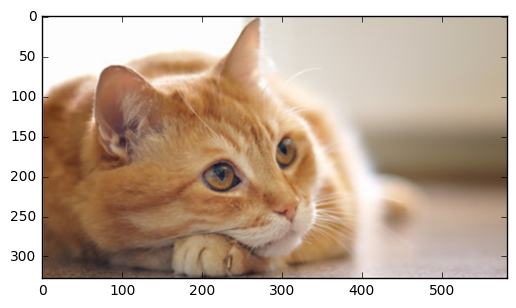

In [2]:
img = Image.open('cat.jpg').convert('RGB')
img = np.array(img)/255.0
plt.imshow(img)

In [3]:
img_batch = np.expand_dims(img, 0)
inputImages = torch.from_numpy(img_batch.astype(np.float32))
inputImages.size()
s = STN()
g = GridGen(328, 582)
input = Variable(torch.from_numpy(np.array([[[1, 0.5, 0], [0.5, 1, 0]]], dtype=np.float32)), requires_grad = True)
#print input
out = g(input)
input1 = Variable(inputImages)
res = s(input1, out)
res = res.data.numpy()

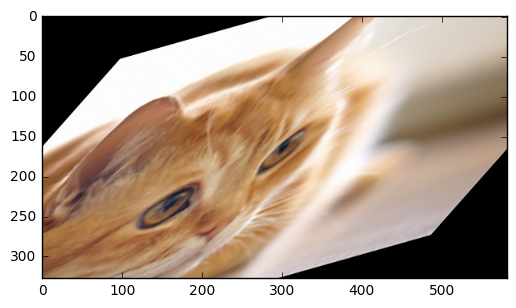

In [4]:
plt.imshow(res[0])

In [5]:
target = Variable(torch.from_numpy(res))

In [6]:
print input1.size(), target.size()

torch.Size([1, 328, 582, 3]) torch.Size([1, 328, 582, 3])


In [7]:
crt = nn.L1Loss()

In [8]:
crt.forward(input1, target)

Variable containing:
 0.2754
[torch.FloatTensor of size 1]

In [9]:
class Transformer(nn.Module):
    def __init__(self):
        super(Transformer, self).__init__()
        self.s = STN()
        self.g = GridGen(328, 582, lr = 0.01)
    def forward(self,input1, input2):
        out = self.g(input2)
        out2 = self.s(input1, out)
        return out2

In [10]:
t = Transformer()

In [11]:
input1 = input1
input2 = Variable(torch.from_numpy(np.array([[[1, 0.5, 0], [0.5, 1, 0]]], dtype=np.float32) + 0.1*np.random.random((1,2,3)).astype(np.float32)) , requires_grad = True)
crt = nn.L1Loss()

In [12]:
input2

Variable containing:
(0 ,.,.) = 
  1.0108  0.5815  0.0598
  0.5239  1.0200  0.0773
[torch.FloatTensor of size 1x2x3]

In [15]:
for i in range(100):
    out = t(input1, input2)
    err = crt(out, target)
    err.backward()

    input2.data = input2.data - 0.000001*input2.grad.data
    #plt.imshow(out.data.numpy()[0])
    print err.data[0]


0.112102046609
0.112095996737
0.112089551985
0.112083442509
0.112077005208
0.112070657313
0.112064830959
0.112058728933
0.112052373588
0.112046048045
0.112039841712
0.112033441663
0.112027399242
0.11202095449
0.112014681101
0.112008161843
0.112001948059
0.111995525658
0.111988797784
0.111982367933
0.111976139247
0.111969813704
0.111962653697
0.111956223845
0.111949138343
0.111942999065
0.111936889589
0.111929833889
0.111923590302
0.111916795373
0.11191046983
0.111904166639
0.111897528172
0.111891180277
0.111885160208
0.111878283322
0.11187183857
0.111865721643
0.111858852208
0.111852221191
0.11184566468
0.111839443445
0.111833110452
0.111826881766
0.111820116639
0.111813478172
0.111806936562
0.111800298095
0.11179394275
0.111787222326
0.111780047417
0.111773528159
0.111767068505
0.111760154366
0.111753664911
0.111746661365
0.111739970744
0.111733749509
0.111727267504
0.111720725894
0.111714348197
0.111707389355
0.111700437963
0.111693747342
0.111687086523
0.111680597067
0.1116739586
0.

In [16]:
input2.grad

Variable containing:
(0 ,.,.) = 
 -1.0259 -0.0313  4.5476
 -0.5921 -0.6834  6.9870
[torch.FloatTensor of size 1x2x3]

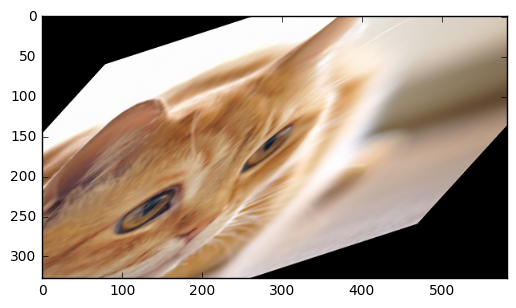

In [17]:
plt.imshow(out.data.numpy()[0])

In [18]:
input2

Variable containing:
(0 ,.,.) = 
  1.0113  0.5815  0.0575
  0.5242  1.0203  0.0738
[torch.FloatTensor of size 1x2x3]